1. Initial Exploration & Column Categorization
Since data types might be incorrect due to missing values, start by identifying column types based on actual content, rather than relying on df.dtypes.

Key Steps:
Get an overview of missing values and unique counts.
Identify numeric columns (int64, float64) and check if floats can be converted to integers.
Identify categorical/text columns and check for inconsistencies.
Group columns based on relevance, such as:
Identifiers (e.g., IDs, names)
Date/time variables
Financial/quantitative variables
Categorical variables
Text-based variables (e.g., descriptions)
Code Example:
python
Copy
Edit
import pandas as pd

# Identify missing values and unique values
missing_counts = df.isnull().sum()
unique_counts = df.nunique()

# Identify potential int columns (floats with no decimals)
float_cols = df.select_dtypes(include=['float64']).columns
int_candidates = [col for col in float_cols if df[col].dropna().mod(1).eq(0).all()]

# Convert them
df[int_candidates] = df[int_candidates].astype("Int64")  # Pandas nullable integer type

# Categorizing columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
date_cols = [col for col in df.columns if 'date' in col.lower()]  # Adjust based on known data
2. Handling Missing Data
Instead of dropping missing values blindly, handle them based on the column type:

Numeric Columns: Impute with mean, median, or zero depending on context.
Categorical Columns: Fill with mode, "Unknown", or "Missing" if it makes sense.
Dates: Forward/backward fill where logical.
Code Example:
python
Copy
Edit
# Fill missing values
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)  # Use median to avoid skewing

for col in categorical_cols:
    df[col].fillna("Unknown", inplace=True)  # Assign "Unknown" to missing text data
3. Standardizing Text Data
Convert categorical/text values to consistent casing.
Strip leading/trailing spaces.
Handle potential inconsistencies like "NY" vs. "New York".
Code Example:
python
Copy
Edit
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()  # Standardize text
4. Detecting Outliers & Incorrect Entries
For numeric data, use IQR (Interquartile Range) to find outliers and decide how to handle them.
For categorical data, check for inconsistent spellings or values that don’t belong.

Code Example:
python
Copy
Edit
from scipy.stats import iqr

# Identify outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    print(f"{col}: {outliers.sum()} potential outliers")
5. Correcting Data Types
Once missing values are handled and text is standardized, convert data types properly:

Ensure date columns are datetime64.
Ensure categorical variables use category dtype for efficiency.
Ensure floats that should be integers are properly converted.
Code Example:
python
Copy
Edit
# Convert date columns
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Convert categorical columns to category dtype
for col in categorical_cols:
    df[col] = df[col].astype("category")
6. Automating the Cleaning Process
To make this repeatable, wrap steps in functions and call them in sequence:

python
Copy
Edit
def clean_numeric_data(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    int_candidates = [col for col in float_cols if df[col].dropna().mod(1).eq(0).all()]
    df[int_candidates] = df[int_candidates].astype("Int64")  # Convert cleanable floats to int
    
    for col in df.select_dtypes(include=['int64', 'float64']):
        df[col].fillna(df[col].median(), inplace=True)
    
    return df

def clean_categorical_data(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip().str.lower().fillna("unknown")
    
    return df

def clean_date_data(df):
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    
    return df

def clean_dataset(df):
    df = clean_numeric_data(df)
    df = clean_categorical_data(df)
    df = clean_date_data(df)
    return df

# Apply the cleaning process
df_cleaned = clean_dataset(df)

Step 1: Initial Exploration & Data Type Validation
Before cleaning, we need to identify issues such as:

Columns with mixed data types (e.g., numeric columns containing strings).
Columns that should be categorical but have too many unique values.
Columns with missing values and their proportions.
Logic & Approach:
If a column is supposed to be numeric but has more than 5% of unique non-numeric values, flag it as "potentially corrupted."
If a column has a small number of unique values compared to total rows, it might be categorical instead of text.
Code Implementation:
python
Copy
Edit
import pandas as pd
import numpy as np

def detect_mixed_data_types(df):
    """
    Identify columns with mixed data types and flag them for correction.
    """
    potential_issues = {}

    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        num_numeric = sum(pd.to_numeric(unique_vals, errors='coerce').notna())
        num_strings = len(unique_vals) - num_numeric
        
        # If more than 5% of unique values are non-numeric in a numeric-looking column, flag it
        if num_strings > 0 and num_strings / len(unique_vals) > 0.05:
            potential_issues[col] = {
                'total_unique': len(unique_vals),
                'num_numeric': num_numeric,
                'num_strings': num_strings
            }
    
    return potential_issues

# Run the detection function
mixed_type_columns = detect_mixed_data_types(df)
print("Potential mixed-type columns:", mixed_type_columns)
📌 Outcome: This function flags columns with numeric contamination and prepares them for conversion in Step 7.

Step 2: Missing Value Handling
Group-Based Imputation

If a column has missing values, fill them using the median/mean within each group (e.g., Country → Inflation Rate).
Forward & Backward Fill for Time Series

If the dataset contains time-based data, fill missing values based on trends.
Code Implementation:
python
Copy
Edit
def impute_by_group(df, target_col, group_col, method='median'):
    """
    Fill missing values in 'target_col' based on group-wise values in 'group_col'.
    """
    if method == 'median':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
    
    return df

# Example usage: Fill Inflation_Rate based on Country
df = impute_by_group(df, target_col='Inflation_Rate', group_col='Country', method='median')

# Forward & Backward Fill for Time Series
df = df.sort_values(by=['Date']).groupby('Country').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
Step 3: Standardizing Text Data
Convert text to lowercase, strip spaces, and correct spelling inconsistencies using fuzzy matching.
Detect near-duplicate categorical values and map them to a standard format.
Code Implementation:
python
Copy
Edit
from fuzzywuzzy import process

def standardize_text(df, col, reference_values=None, threshold=90):
    """
    Standardize categorical values by matching them to a reference list using fuzzy matching.
    """
    if reference_values is None:
        reference_values = df[col].dropna().unique()  # Use unique existing values if no reference

    df[col] = df[col].apply(lambda x: process.extractOne(x, reference_values)[0] if pd.notna(x) else x)
    return df

# Example usage: Standardize 'Country' names
df = standardize_text(df, 'Country', reference_values=['United States', 'Canada', 'United Kingdom'])
Step 4: Detecting & Handling Duplicates
Instead of removing duplicates outright, we use fuzzy matching for near-duplicates.

Code Implementation:
python
Copy
Edit
from fuzzywuzzy import fuzz

def detect_near_duplicates(df, col, threshold=90):
    """
    Identify near-duplicate values in a column using fuzzy string matching.
    """
    unique_vals = df[col].dropna().unique()
    duplicates = {}

    for val in unique_vals:
        match = process.extractOne(val, unique_vals)
        if match and match[1] >= threshold and val != match[0]:
            duplicates[val] = match[0]  # Map incorrect to correct

    return duplicates

# Example usage: Find duplicate company names
duplicate_mappings = detect_near_duplicates(df, 'Company_Name')

# Replace incorrect names with correct ones
df['Company_Name'] = df['Company_Name'].replace(duplicate_mappings)
Step 5: Outlier Detection & Winsorization
Instead of removing extreme values, cap them at the 5th and 95th percentile.

Code Implementation:
python
Copy
Edit
from scipy.stats.mstats import winsorize

def winsorize_column(df, col, lower=0.05, upper=0.05):
    """
    Winsorize column by capping extreme values at given percentiles.
    """
    df[col] = winsorize(df[col], limits=[lower, upper])
    return df

# Example usage: Winsorize Sales data
df = winsorize_column(df, 'Sales')
Step 6: Regression Imputation for Missing Values
Use a regression model to predict missing values based on correlated features.

Code Implementation:
python
Copy
Edit
from sklearn.linear_model import LinearRegression

def regression_impute(df, target_col, feature_cols):
    """
    Predict and fill missing values in 'target_col' using a regression model based on 'feature_cols'.
    """
    train_data = df.dropna(subset=[target_col])  # Remove rows where target_col is NaN
    test_data = df[df[target_col].isna()]  # Rows where target_col is missing

    model = LinearRegression()
    model.fit(train_data[feature_cols], train_data[target_col])

    df.loc[df[target_col].isna(), target_col] = model.predict(test_data[feature_cols])
    return df

# Example usage: Predict missing Salaries based on Experience & Education
df = regression_impute(df, target_col='Salary', feature_cols=['Experience', 'Education_Level'])
Step 7: Correcting Mixed Data Types
Detect numeric columns with string contamination (Step 1).
Convert them to numeric while handling errors.
Fill remaining NaNs with median values.
Code Implementation:
python
Copy
Edit
def fix_mixed_data_types(df, mixed_columns):
    """
    Convert flagged mixed-type columns to numeric, handling errors and filling NaNs.
    """
    for col in mixed_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
        df[col].fillna(df[col].median(), inplace=True)  # Fill missing values
    
    return df

# Apply the fix
df = fix_mixed_data_types(df, mixed_type_columns.keys())
Final Thoughts
This cleaning process is: ✔ Modular – Each step is a function that can be reused.
✔ Scalable – Works for large datasets with 100k+ rows.
✔ Transparent – Provides explanations for each transformation.

# Implentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn import cluster
import sklearn
import seaborn as sns
from sklearn import decomposition
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# allow us to see all columns
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("../Datasets_P1/df_Cost.csv")
df.sample(5)

C:\Users\perreaultl1\AppData\Local\Temp\ipykernel_21440\3932104159.py:1: DtypeWarning: Columns (8,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Datasets_P1/df_Cost.csv")


rpt_rec_num  Provider_CCN                   Facility_Name  \
68277      1276152        155442       HICKORY CREEK AT FRANKLIN   
3850       1138514        335631       CHAPIN HOME FOR THE AGING   
97917      1332183        195214               PRESTIGE CARE LLC   
56446      1250602        366068                   ORCHARD VILLA   
47830      1231448        676436  THE MEDICAL RESORT AT PEARLAND   

                Street_Address         City State_Code    Zip_Code    County  \
68277          1130 N. MAIN ST     FRANKLIN         IN       46131   JOHNSON   
3850     165-01 CHAPIN PARKWAY      JAMAICA         NY  11432-1897    QUEENS   
97917    4500 HAYNES BOULEVARD  NEW ORLEANS         LA       70128   ORLEANS   
56446       2841 MUNDING DRIVE       OREGON         OH       43616     LUCAS   
47830  3406 BUSINESS CENTER DR     PEARLAND         TX       77584  BRAZORIA   

      Medicare_CBSA_Number Rural_versus_Urban Fiscal_Year_Begin_Date  \
68277              26900.0                  R               1/1/2019   
3850                   NaN                NaN                    NaN   
97917              35380.0                  U             01/01/2021   
56446              45780.0                  U               1/1/2018   
47830              26420.0                  U              2/22/2018   

      Fiscal_Year_End_Date  Type_of_Control  Accounts_Receivable  \
68277           12/31/2019              4.0             241122.0   
3850                   NaN              4.0                  NaN   
97917           12/31/2021              5.0            7399852.0   
56446           12/31/2018              4.0             755411.0   
47830           12/31/2018              4.0             930427.0   

       Accounts_payable  Buildings  Cash_on_hand_and_in_banks  \
68277           63041.0   169646.0                   519969.0   
3850                NaN        NaN                        NaN   
97917          177219.0  2931952.0                   684462.0   
56446          253320.0        NaN                  1268622.0   
47830         1762207.0        NaN                   379027.0   

       General_fund_balance  Gross_Revenue  Inpatient_PPS_Amount  \
68277              423820.0      2265115.0               13609.0   
3850                    NaN            NaN                   NaN   
97917             8345189.0     10060938.0              920906.0   
56446            -1607630.0     16016409.0             2306618.0   
47830            -2138025.0      4465754.0             2970731.0   

       Inpatient_Revenue  Less_Total_Operating_Expense  \
68277          2265115.0                     2639888.0   
3850                 NaN                           NaN   
97917         10060938.0                    11131202.0   
56446         16016409.0                    11374168.0   
47830          4465754.0                     5524468.0   

       Less_discounts_on_patients  Major_movable_equipment  Net_Income  \
68277                   -492667.0                 168198.0    123120.0   
3850                          NaN                      NaN         NaN   
97917                   -168211.0                1581632.0   -428153.0   
56446                   4516756.0                      NaN    284642.0   
47830                   1037704.0                      NaN  -2096259.0   

       Net_Patient_Revenue  Number_of_Beds  Other_Assets  \
68277            2757782.0            36.0      672231.0   
3850                   NaN             NaN           NaN   
97917           10229149.0           200.0           NaN   
56446           11499653.0           136.0           NaN   
47830            3428050.0           104.0           NaN   

       Other_current_liabilities  Overhead_Non_Salary_Costs  \
68277                   544216.0                  1711348.0   
3850                         NaN                        NaN   
97917                   342584.0                  6081408.0   
56446                   222672.0                  5123927.0   
47830

Text(0.5, 1.0, 'Missing Values Heatmap')

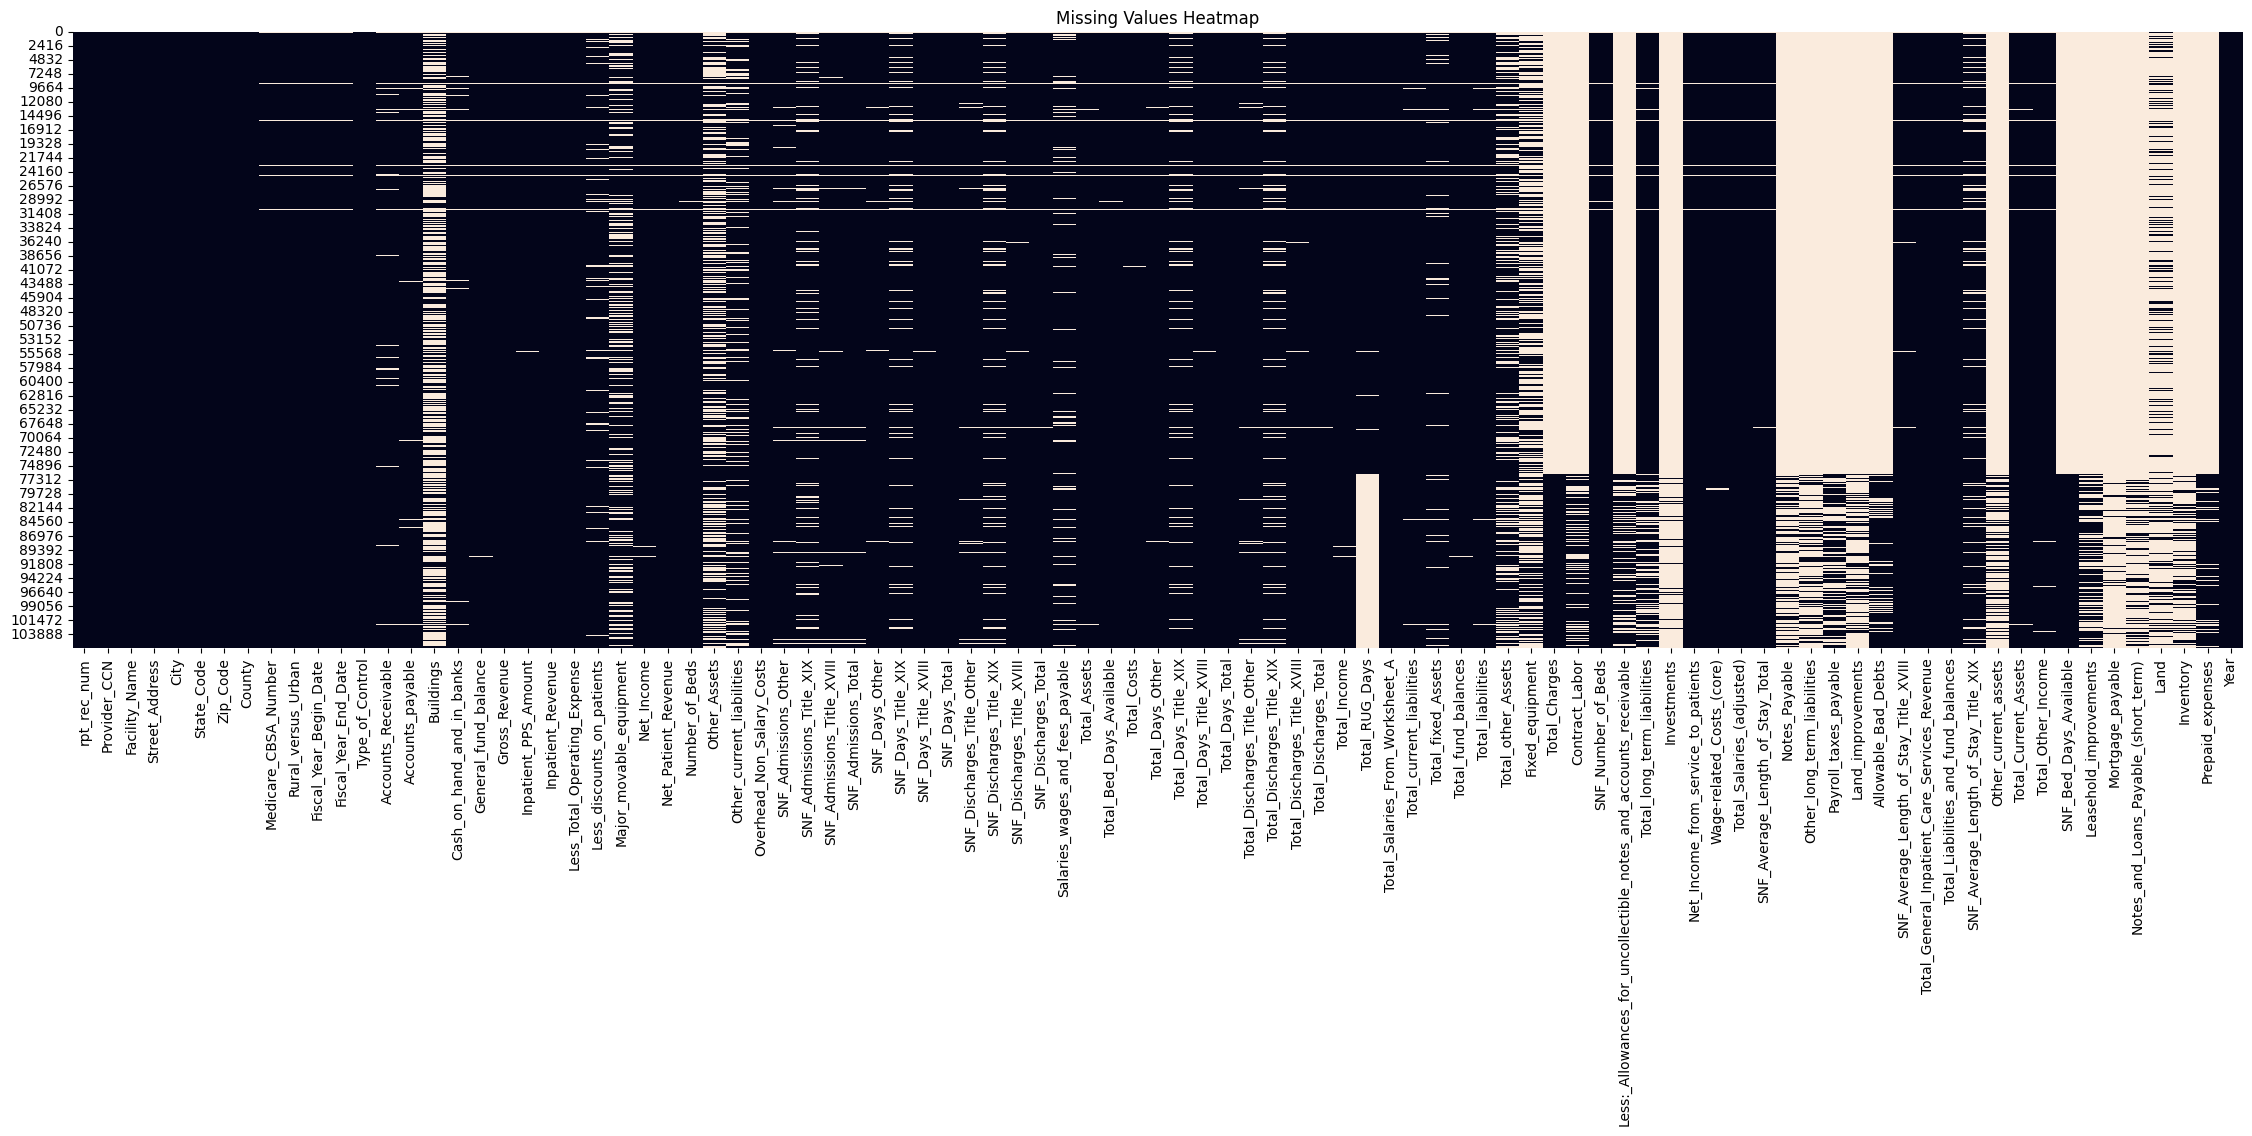

In [4]:
plt.figure(figsize=(28, 8))
sns.heatmap(df.isnull(), cbar=False)   # and do df21
plt.title("Missing Values Heatmap")

# Deal with Target

In [5]:
# Count of missing Net_Income values
num_missing_net_income = df['Net_Income'].isna().sum()

# Count of observations missing 50% or more of their data
num_cols = df.shape[1]  # Total number of columns
num_missing_50 = (df.isna().sum(axis=1) >= num_cols * 0.5).sum()

# Count of observations that satisfy both conditions
num_both_conditions = ((df['Net_Income'].isna()) & (df.isna().sum(axis=1) >= num_cols * 0.5)).sum()

# Print results
print(f"Count of NA Net_Income: {num_missing_net_income}")
print(f"Count of rows missing 50%+ of their data: {num_missing_50}")
print(f"Count of rows with both NA Net_Income and 50%+ missing data: {num_both_conditions}")


Count of NA Net_Income: 2360
Count of rows missing 50%+ of their data: 2118
Count of rows with both NA Net_Income and 50%+ missing data: 2074


In [6]:
# Executive Decision is to take out of the rows with more than 50% missing AND NA Net Income.
# The rest of the missing Net_Income Na I will see if I can calculate. 
# Get total column count
num_cols = df.shape[1]

# Create a mask for both conditions
mask_to_drop = (df['Net_Income'].isna()) & (df.isna().sum(axis=1) > num_cols * 0.5)

# Drop those rows
df = df[~mask_to_drop].copy()  # Keep the rest of the data

# Print confirmation
num_dropped = mask_to_drop.sum()
print(f"Dropped {num_dropped} rows that had NA Net_Income AND more than 50% missing data.")

# Remaining Net_Income missing values (to be calculated later)
remaining_na_net_income = df['Net_Income'].isna().sum()
print(f"Remaining missing Net_Income values to handle: {remaining_na_net_income}")


Dropped 2074 rows that had NA Net_Income AND more than 50% missing data.
Remaining missing Net_Income values to handle: 286


In [7]:
selected_columns = ['Gross_Revenue', 'Net_Income', 'Total_Costs', 'Total_Income', "Less_Total_Operating_Expense", "Overhead_Non_Salary_Costs", "Net_Income_from_service_to_patients", "Net_Patient_Revenue"]
df_selected = df[selected_columns].copy()  # Create a separate dataframe

# Display the first few rows to check
df_selected.tail(3)
# I just found out that total income and net income are the same thing and have the same values. 

Gross_Revenue  Net_Income  Total_Costs  Total_Income  \
106266      9009085.0   1916693.0    1111339.0     1916693.0   
106267     12738362.0   1188367.0    1250246.0     1188367.0   
106268      9991720.0    739852.0    1493029.0      739852.0   

        Less_Total_Operating_Expense  Overhead_Non_Salary_Costs  \
106266                     6086547.0                  2799973.0   
106267                    15288127.0                  9249788.0   
106268                     9536736.0                  4401409.0   

        Net_Income_from_service_to_patients  Net_Patient_Revenue  
106266                            1391159.0            7477706.0  
106267                           -2549765.0           12738362.0  
106268                             454984.0            9991720.0

In [8]:
# Calculate 'netincometest' for the entire dataset
df_selected['netincometest'] = df_selected['Gross_Revenue'] - (df_selected['Total_Costs'])

# Display the first few rows to check
df_selected[['Gross_Revenue', 'Total_Costs', 'Less_Total_Operating_Expense', 'Net_Income' , 'netincometest']].head()


Gross_Revenue  Total_Costs  Less_Total_Operating_Expense  Net_Income  \
0      1800296.0     211585.0                     1209322.0    311430.0   
1      2843541.0     207903.0                     3005301.0   -588469.0   
2       613243.0      22920.0                      639168.0    -47859.0   
3      1935277.0     158386.0                     1444469.0    -63638.0   
4       818175.0      56556.0                      775242.0     -1613.0   

   netincometest  
0      1588711.0  
1      2635638.0  
2       590323.0  
3      1776891.0  
4       761619.0

I cannot calaculate Net_Income. I will drop the 286 rows. I can use it later in the model I build perhaps. I will drop at the very end then so I fill in the NA in the other rows.

# Step 1: Initial Exploration & Data Type Validation


## Exploring data types 
Trying to see variables with 1 to 5% of values that their data type are different from the rest. 

In [9]:
import pandas as pd
import numpy as np

def detect_mixed_data_types(df):
    """
    Identify columns with mixed data types and separate those with mostly numeric values but minor string contamination.
    """
    potential_issues = {}
    mostly_numeric_columns = {}

    for col in df.columns:
        unique_vals = pd.Series(df[col].dropna().unique())  # Convert to pandas Series
        num_numeric = sum(pd.to_numeric(unique_vals, errors='coerce').notna())
        num_strings = len(unique_vals) - num_numeric
        total_unique = len(unique_vals)

        if total_unique > 0:  # Avoid division by zero
            string_ratio = num_strings / total_unique
            numeric_ratio = num_numeric / total_unique

            # Flag columns with significant mixed data issues (>5% strings)
            if string_ratio >= 0.05:
                potential_issues[col] = {
                    'total_unique': total_unique,
                    'num_numeric': num_numeric,
                    'num_strings': num_strings
                }

            # Identify columns that are **mostly numeric** but contain **at least one string** (0% < string_ratio < 5%)
            if 0 < string_ratio < 0.05:
                mostly_numeric_columns[col] = {
                    'total_unique': total_unique,
                    'num_numeric': num_numeric,
                    'num_strings': num_strings
                }

    return potential_issues, mostly_numeric_columns

# Run the function
mixed_type_columns, mostly_numeric_columns = detect_mixed_data_types(df)

print("Potential mixed-type columns with significant string contamination:", mixed_type_columns)
print("\nColumns that are mostly numeric but contain <5% strings:", mostly_numeric_columns)


Potential mixed-type columns with significant string contamination: {'Facility_Name': {'total_unique': 22293, 'num_numeric': 1, 'num_strings': 22292}, 'Street_Address': {'total_unique': 19049, 'num_numeric': 15, 'num_strings': 19034}, 'City': {'total_unique': 5569, 'num_numeric': 2, 'num_strings': 5567}, 'State_Code': {'total_unique': 52, 'num_numeric': 0, 'num_strings': 52}, 'Zip_Code': {'total_unique': 11564, 'num_numeric': 9463, 'num_strings': 2101}, 'County': {'total_unique': 2154, 'num_numeric': 9, 'num_strings': 2145}, 'Rural_versus_Urban': {'total_unique': 2, 'num_numeric': 0, 'num_strings': 2}, 'Fiscal_Year_Begin_Date': {'total_unique': 1003, 'num_numeric': 0, 'num_strings': 1003}, 'Fiscal_Year_End_Date': {'total_unique': 928, 'num_numeric': 0, 'num_strings': 928}}

Columns that are mostly numeric but contain <5% strings: {'Medicare_CBSA_Number': {'total_unique': 1361, 'num_numeric': 1360, 'num_strings': 1}, 'Land': {'total_unique': 5029, 'num_numeric': 5028, 'num_strings': 1}}

In [10]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, process  # Faster alternative to fuzzywuzzy

def detect_and_match_strings(df, similarity_threshold=70):
    """
    Identify mostly numeric columns with minor string contamination and find values with high similarity (70%+).
    """
    mostly_numeric_columns = {}

    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        unique_vals_str = pd.Series(unique_vals, dtype=str)  # Convert all values to string

        # Identify which values are truly numeric vs. string
        num_numeric = sum(pd.to_numeric(unique_vals_str, errors='coerce').notna())
        num_strings = len(unique_vals_str) - num_numeric
        total_unique = len(unique_vals_str)

        if total_unique > 0:  # Avoid division by zero
            string_ratio = num_strings / total_unique

            # Identify mostly numeric columns with minor string contamination
            if 0 < string_ratio < 0.05:
                true_string_values = [val for val in unique_vals_str if not val.replace('.', '', 1).isdigit()]

                # Convert only strings for fuzzy matching
                unique_string_vals = [str(val) for val in unique_vals_str if not val.replace('.', '', 1).isdigit()]
                
                # Find similar values using fuzzy matching
                similar_values = {}
                for string_val in true_string_values:
                    matches = process.extract(string_val, unique_string_vals, scorer=fuzz.ratio, limit=10)
                    high_similarity_matches = [match[0] for match in matches if match[1] >= similarity_threshold]

                    if high_similarity_matches:
                        similar_values[string_val] = high_similarity_matches

                mostly_numeric_columns[col] = {
                    'total_unique': total_unique,
                    'num_numeric': num_numeric,
                    'num_strings': num_strings,
                    'string_values': true_string_values,
                    'similar_values': similar_values
                }

    return mostly_numeric_columns

# Run the function
mostly_numeric_columns = detect_and_match_strings(df)

# Display results
for col, details in mostly_numeric_columns.items():
    print(f"\nColumn: {col}")
    print(f"Total Unique Values: {details['total_unique']}")
    print(f"Numeric Values Count: {details['num_numeric']}")
    print(f"String Values Count: {details['num_strings']}")
    print(f"String Values Found: {details['string_values']}")
    print(f"Similar Values (90%+ match): {details['similar_values']}")  # Shows matched values



Column: Medicare_CBSA_Number
Total Unique Values: 1361
Numeric Values Count: 1360
String Values Count: 1
String Values Found: ['999PA']
Similar Values (90%+ match): {'999PA': ['999PA']}

Column: Land
Total Unique Values: 5029
Numeric Values Count: 5028
String Values Count: 1
String Values Found: ['Provider_CCN\n145842    40000.0\n145842     6000.0\nName: Land, dtype: float64']
Similar Values (90%+ match): {'Provider_CCN\n145842    40000.0\n145842     6000.0\nName: Land, dtype: float64': ['Provider_CCN\n145842    40000.0\n145842     6000.0\nName: Land, dtype: float64']}


In [11]:
def replace_value(df, column, old_value, new_value):
    """
    Replace a specific value in a given column with a new value.
    
    Parameters:
    df (pd.DataFrame): The dataframe.
    column (str): The column where the replacement should happen.
    old_value (str/int/float): The value to be replaced.
    new_value (str/int/float): The value to replace it with.
    
    Returns:
    pd.DataFrame: Updated dataframe with the replaced values.
    """
    df[column] = df[column].replace(old_value, new_value)
    return df

# Example Usage:
df = replace_value(df, column='Medicare_CBSA_Number', old_value='999PA', new_value='999221')


In [12]:
def replace_value(df, column, old_value, new_value):
    """
    Replace a specific value in a given column with a new value.
    
    Parameters:
    df (pd.DataFrame): The dataframe.
    column (str): The column where the replacement should happen.
    old_value (str/int/float): The value to be replaced.
    new_value (str/int/float): The value to replace it with.
    
    Returns:
    pd.DataFrame: Updated dataframe with the replaced values.
    """
    df[column] = df[column].replace(old_value, new_value)
    return df

# Example Usage:
df = replace_value(df, column='Land', old_value='Provider_CCN\n145842    40000.0\n145842     6000.0\nName: Land, dtype: float64', new_value='0')

# Split the columns by data type: 
This will allow me to apply Missing value handling to multiple variables at once. 

In [13]:
import pandas as pd

def split_dataset_by_na_and_type(df):
    """
    Splits dataset into columns with and without NaN values, then further splits the NaN dataset by data type and unique values.
    
    Returns:
    - df_without_na: DataFrame with columns that have no NaN values
    - Multiple DataFrames for columns with NaN, split by data type and unique value count.
    """
    
    # Step 1: Split dataset by columns with NaNs and without NaNs
    df_with_na = df.loc[:, df.isna().any()]
    df_without_na = df.loc[:, ~df.isna().any()]
    
    # Step 2: Split by data type
    df_numeric = df_with_na.select_dtypes(include=['int64', 'float64'])
    df_string = df_with_na.select_dtypes(include=['object'])
    df_boolean = df_with_na.select_dtypes(include=['bool'])
    
    # Step 3: Further split by number of unique values
    def split_by_unique_values(df, threshold=50):
        """ Splits a DataFrame into two: < threshold unique values & ≥ threshold unique values. """
        low_unique = [col for col in df.columns if df[col].nunique() < threshold]
        high_unique = [col for col in df.columns if df[col].nunique() >= threshold]
        
        return df[low_unique], df[high_unique]
    
    # Apply to each type of column
    df_numeric_low_unique, df_numeric_high_unique = split_by_unique_values(df_numeric)
    df_string_low_unique, df_string_high_unique = split_by_unique_values(df_string)
    df_boolean_low_unique, df_boolean_high_unique = split_by_unique_values(df_boolean)

    return {
        "df_without_na": df_without_na,
        "df_numeric_low_unique": df_numeric_low_unique,
        "df_numeric_high_unique": df_numeric_high_unique,
        "df_string_low_unique": df_string_low_unique,
        "df_string_high_unique": df_string_high_unique,
        "df_boolean_low_unique": df_boolean_low_unique,
        "df_boolean_high_unique": df_boolean_high_unique
    }

# Run the function
split_dfs = split_dataset_by_na_and_type(df)

# Access the resulting DataFrames
df_without_na = split_dfs["df_without_na"]
df_numeric_low_unique = split_dfs["df_numeric_low_unique"]
df_numeric_high_unique = split_dfs["df_numeric_high_unique"]
df_string_low_unique = split_dfs["df_string_low_unique"]
df_string_high_unique = split_dfs["df_string_high_unique"]
df_boolean_low_unique = split_dfs["df_boolean_low_unique"]
df_boolean_high_unique = split_dfs["df_boolean_high_unique"]

# Display results
print("Columns without NaN:", df_without_na.columns.tolist())
print("Numeric Columns (<50 unique):", df_numeric_low_unique.columns.tolist())
print("Numeric Columns (≥50 unique):", df_numeric_high_unique.columns.tolist())
print("String Columns (<50 unique):", df_string_low_unique.columns.tolist())
print("String Columns (≥50 unique):", df_string_high_unique.columns.tolist())
print("Boolean Columns (<50 unique):", df_boolean_low_unique.columns.tolist())
print("Boolean Columns (≥50 unique):", df_boolean_high_unique.columns.tolist())


Columns without NaN: ['rpt_rec_num', 'Provider_CCN', 'Facility_Name', 'City', 'State_Code', 'Zip_Code', 'County', 'Fiscal_Year_Begin_Date', 'Fiscal_Year_End_Date', 'Type_of_Control', 'Overhead_Non_Salary_Costs', 'Year']
Numeric Columns (<50 unique): []
Numeric Columns (≥50 unique): ['Accounts_Receivable', 'Accounts_payable', 'Buildings', 'Cash_on_hand_and_in_banks', 'General_fund_balance', 'Gross_Revenue', 'Inpatient_PPS_Amount', 'Inpatient_Revenue', 'Less_Total_Operating_Expense', 'Less_discounts_on_patients', 'Major_movable_equipment', 'Net_Income', 'Net_Patient_Revenue', 'Number_of_Beds', 'Other_Assets', 'Other_current_liabilities', 'SNF_Admissions_Other', 'SNF_Admissions_Title_XIX', 'SNF_Admissions_Title_XVIII', 'SNF_Admissions_Total', 'SNF_Days_Other', 'SNF_Days_Title_XIX', 'SNF_Days_Title_XVIII', 'SNF_Days_Total', 'SNF_Discharges_Title_Other', 'SNF_Discharges_Title_XIX', 'SNF_Discharges_Title_XVIII', 'SNF_Discharges_Total', 'Salaries_wages_and_fees_payable', 'Total_Assets', 'Tota

# Visualization
Before we decide how to hamdle the NA values I want to visualize the data because it will help make the decision more obvious what to do. 

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_high_unique_numeric(df, numeric_high_unique_cols):
    """
    Creates a dual visualization:
    - Histogram of each high unique numeric column
    - Scatter plot with Net_Income on the y-axis and each column on the x-axis
    """
    fig, axes = plt.subplots(nrows=len(numeric_high_unique_cols), ncols=2, figsize=(12, 5 * len(numeric_high_unique_cols)))

    for idx, col in enumerate(numeric_high_unique_cols):
        # Histogram
        sns.histplot(df[col], bins=50, kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f"Histogram of {col}")
        axes[idx, 0].set_xlabel(col)
        axes[idx, 0].set_ylabel("Count")

        # Scatter plot
        sns.scatterplot(x=df[col], y=df['Net_Income'], ax=axes[idx, 1], alpha=0.5)
        axes[idx, 1].set_title(f"Scatter Plot: {col} vs Net_Income")
        axes[idx, 1].set_xlabel(col)
        axes[idx, 1].set_ylabel("Net_Income")

    plt.tight_layout()
    plt.show()

# Run the visualization function
visualize_high_unique_numeric(df, df_numeric_high_unique.columns.tolist())


Use another script and run this to be able to scroll and use it while handling NAs.

There are way too many outliers. I will handle these first. 

## Handling Outliers to get better visualization.

In [24]:
import pandas as pd
from scipy.stats import iqr
from scipy.stats.mstats import winsorize

# Outlier detection using IQR but im doing it by 15 and 85 percentiles 
def detect_outliers(df):
    numeric_cols = df.select_dtypes(include='number').columns
    outliers_dict = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        IQR_value = Q3 - Q1
        outliers = ((df[col] < (Q1 - 1.5 * IQR_value)) | (df[col] > (Q3 + 1.5 * IQR_value)))
        outliers_dict[col] = outliers.sum()
        print(f"{col}: {outliers.sum()} potential outliers")

    return outliers_dict

# Winsorizing function with 2nd and 98th percentiles
def winsorize_column(df, col, lower=0.02, upper=0.98):
    """
    Winsorizes a column by capping extreme values at the 2nd and 98th percentiles.
    """
    lower_limit = df[col].quantile(lower)
    upper_limit = df[col].quantile(upper)
    
    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    return df

# Detecting outliers
print("Outliers detected using IQR:")
outliers = detect_outliers(df_numeric_high_unique)


Outliers detected using IQR:
Accounts_Receivable: 1538 potential outliers
Accounts_payable: 1554 potential outliers
Buildings: 369 potential outliers
Cash_on_hand_and_in_banks: 2062 potential outliers
General_fund_balance: 2124 potential outliers
Gross_Revenue: 411 potential outliers
Inpatient_PPS_Amount: 336 potential outliers
Inpatient_Revenue: 395 potential outliers
Less_Total_Operating_Expense: 563 potential outliers
Less_discounts_on_patients: 546 potential outliers
Major_movable_equipment: 1105 potential outliers
Net_Income: 926 potential outliers
Net_Patient_Revenue: 489 potential outliers
Number_of_Beds: 274 potential outliers
Other_Assets: 1443 potential outliers
Other_current_liabilities: 1820 potential outliers
SNF_Admissions_Other: 281 potential outliers
SNF_Admissions_Title_XIX: 423 potential outliers
SNF_Admissions_Title_XVIII: 256 potential outliers
SNF_Admissions_Total: 171 potential outliers
SNF_Days_Other: 264 potential outliers
SNF_Days_Title_XIX: 206 potential outli

play with the percentiles because I dont want to change too many values. only extreme outliers. Go through the process and see the output in the graph and maybe go back and adjust as you see fit.

In [25]:
import pandas as pd
from scipy.stats import iqr
from sklearn.preprocessing import RobustScaler

# Outlier detection using IQR
def detect_outliers(df, col, threshold=1.5):
    """
    Detect outliers based on the IQR method.
    """
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    IQR_value = Q3 - Q1
    lower_bound = Q1 - threshold * IQR_value
    upper_bound = Q3 + threshold * IQR_value
    
    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outliers

# Apply RobustScaler only to outliers
def robust_scale_outliers(df, threshold=1.5):
    """
    Apply RobustScaler to all columns with outliers.
    """
    # Loop through numeric columns
    for col in df.select_dtypes(include='number').columns:
        # Detect outliers for the column
        outliers = detect_outliers(df, col, threshold)
        
        # If outliers are detected, apply RobustScaler
        if outliers.any():
            print(f"Scaling outliers in column: {col}")
            # Separate the outliers and non-outliers
            outlier_data = df[outliers]
            non_outlier_data = df[~outliers]
            
            # Apply RobustScaler to outliers
            scaler = RobustScaler()
            outlier_data_scaled = outlier_data.copy()
            outlier_data_scaled[col] = scaler.fit_transform(outlier_data[[col]])

            # Reassemble the DataFrame with outliers scaled and non-outliers unchanged
            df = pd.concat([non_outlier_data, outlier_data_scaled]).sort_index()

    return df

# Example Usage
df_scaled = robust_scale_outliers(df_numeric_high_unique)



Scaling outliers in column: Accounts_Receivable
Scaling outliers in column: Accounts_payable
Scaling outliers in column: Buildings
Scaling outliers in column: Cash_on_hand_and_in_banks
Scaling outliers in column: General_fund_balance
Scaling outliers in column: Gross_Revenue
Scaling outliers in column: Inpatient_PPS_Amount
Scaling outliers in column: Inpatient_Revenue
Scaling outliers in column: Less_Total_Operating_Expense
Scaling outliers in column: Less_discounts_on_patients
Scaling outliers in column: Major_movable_equipment
Scaling outliers in column: Net_Income
Scaling outliers in column: Net_Patient_Revenue
Scaling outliers in column: Number_of_Beds
Scaling outliers in column: Other_Assets
Scaling outliers in column: Other_current_liabilities
Scaling outliers in column: SNF_Admissions_Other
Scaling outliers in column: SNF_Admissions_Title_XIX
Scaling outliers in column: SNF_Admissions_Title_XVIII
Scaling outliers in column: SNF_Admissions_Total
Scaling outliers in column: SNF_Da

In [ ]:
def visualize_high_unique_numeric(df, numeric_high_unique_cols):
    """
    Creates a dual visualization:
    - Histogram of each high unique numeric column
    - Scatter plot with Net_Income on the y-axis and each column on the x-axis
    """
    fig, axes = plt.subplots(nrows=len(numeric_high_unique_cols), ncols=2, figsize=(12, 5 * len(numeric_high_unique_cols)))

    for idx, col in enumerate(numeric_high_unique_cols):
        # Histogram
        sns.histplot(df[col], bins=50, kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f"Histogram of {col}")
        axes[idx, 0].set_xlabel(col)
        axes[idx, 0].set_ylabel("Count")

        # Scatter plot
        sns.scatterplot(x=df[col], y=df['Net_Income'], ax=axes[idx, 1], alpha=0.5)
        axes[idx, 1].set_title(f"Scatter Plot: {col} vs Net_Income")
        axes[idx, 1].set_xlabel(col)
        axes[idx, 1].set_ylabel("Net_Income")

    plt.tight_layout()
    plt.show()

# Run the visualization function
visualize_high_unique_numeric(df_scaled, df_numeric_high_unique.columns.tolist())

## THis is ignoring the Nulls. so nulls aren't included here. 


Now all my variables are rid of large outliers; I can visualize the data lot better now which will assist greatly in filling the NAs. No scaling was done on the data that was not and "outlier". 

# Step 2: Missing Value Handling
We don't want to take out observations or variables if we can.
## Group-Based Imputation

If a column has missing values, fill them using the median/mean within each group (e.g., Country → Inflation Rate).
Forward & Backward Fill for Time Series

If the dataset contains time-based data, fill missing values based on trends.


In [16]:
# based on one group
def impute_by_group(df, target_col, group_col, method='median'):
    """
    Fill missing values in 'target_col' based on group-wise values in 'group_col'.
    """
    if method == 'median':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
    
    return df

# Example usage: Fill Inflation_Rate based on Country
df = impute_by_group(df, target_col='Inflation_Rate', group_col='Country', method='median')

# Forward & Backward Fill for Time Series
df = df.sort_values(by=['Date']).groupby('Country').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


KeyError: 'Country'

In [ ]:
# based on two groups
def impute_by_two_groups(df, target_col, group_col1, group_col2, method='median'):
    """
    Fill missing values in 'target_col' based on group-wise values in 'group_col1' and 'group_col2'.
    """
    if method == 'median':
        df[target_col] = df.groupby([group_col1, group_col2])[target_col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[target_col] = df.groupby([group_col1, group_col2])[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode':
        df[target_col] = df.groupby([group_col1, group_col2])[target_col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
    
    return df

# Example usage: Fill Inflation_Rate based on 'Country' and 'Year'
df = impute_by_two_groups(df, target_col='Inflation_Rate', group_col1='Country', group_col2='Year', method='median')

# Forward & Backward Fill for Time Series
df = df.sort_values(by=['Date']).groupby(['Country', 'Year']).apply(lambda x: x.fillna(method='ffill').fillna(method='bfill')).reset_index(drop=True)


## Regression Based Imputation for Missing Values
Use a regression model to predict missing values based on correlated features.

In [ ]:
from sklearn.linear_model import LinearRegression

def regression_impute(df, target_col, feature_cols):
    """
    Predict and fill missing values in 'target_col' using a regression model based on 'feature_cols'.
    """
    train_data = df.dropna(subset=[target_col])  # Remove rows where target_col is NaN
    test_data = df[df[target_col].isna()]  # Rows where target_col is missing

    model = LinearRegression()
    model.fit(train_data[feature_cols], train_data[target_col])

    df.loc[df[target_col].isna(), target_col] = model.predict(test_data[feature_cols])
    return df

# Example usage: Predict missing Salaries based on Experience & Education
df = regression_impute(df, target_col='Salary', feature_cols=['Experience', 'Education_Level'])


## Basic unkown and 0 

In [ ]:
import pandas as pd
import numpy as np

def fill_nulls_in_column(df, column):
    """
    Replace NaN values in a specific column:
    - Numeric column → Fill with 0
    - String (object) column → Fill with 'Unknown'
    """
    if column in df.columns:
        if df[column].dtype == 'object':  # If column is string (object type)
            df[column] = df[column].fillna('Unknown')
        else:  # If column is numeric (int/float)
            df[column] = df[column].fillna(0)
    else:
        print(f"Column '{column}' not found in the DataFrame.")
    
    return df

# Example usage
df = fill_nulls_in_column(df, 'Net_Incme')  # Fill missing values in 'whatever column'


# Step 3: Standardizing Text Data
Convert text to lowercase, strip spaces, and correct spelling inconsistencies using fuzzy matching.
Detect near-duplicate categorical values and map them to a standard format.# 

In [ ]:
#pip install fuzzywuzzy 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from fuzzywuzzy import process

def standardize_text(df, col, reference_values=None, threshold=90):
    """
    Standardize categorical values by matching them to a reference list using fuzzy matching.
    """
    if reference_values is None:
        reference_values = df[col].dropna().unique()  # Use unique existing values if no reference

    df[col] = df[col].apply(lambda x: process.extractOne(x, reference_values)[0] if pd.notna(x) else x)
    return df

# Example usage: Standardize 'Country' names
df = standardize_text(df, 'Country', reference_values=['United States', 'Canada', 'United Kingdom'])


C:\Users\perreaultl1\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


KeyError: 'Country'

# Step 4: Detecting & Handling Duplicates
Instead of removing duplicates outright, we use fuzzy matching for near-duplicates.

In [ ]:
from fuzzywuzzy import fuzz

def detect_near_duplicates(df, col, threshold=90):
    """
    Identify near-duplicate values in a column using fuzzy string matching.
    """
    unique_vals = df[col].dropna().unique()
    duplicates = {}

    for val in unique_vals:
        match = process.extractOne(val, unique_vals)
        if match and match[1] >= threshold and val != match[0]:
            duplicates[val] = match[0]  # Map incorrect to correct

    return duplicates

# Example usage: Find duplicate company names
duplicate_mappings = detect_near_duplicates(df, 'Company_Name')

# Replace incorrect names with correct ones
df['Company_Name'] = df['Company_Name'].replace(duplicate_mappings)


# Step 5: Outlier Detection & Winsorization
Instead of removing extreme values, cap them at the 5th and 95th percentile.

In [ ]:
import pandas as pd
from scipy.stats import iqr
from scipy.stats.mstats import winsorize

# Outlier detection using IQR
def detect_outliers(df):
    numeric_cols = df.select_dtypes(include='number').columns
    outliers_dict = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR_value = Q3 - Q1
        outliers = ((df[col] < (Q1 - 1.5 * IQR_value)) | (df[col] > (Q3 + 1.5 * IQR_value)))
        outliers_dict[col] = outliers.sum()
        print(f"{col}: {outliers.sum()} potential outliers")

    return outliers_dict

# Winsorizing function with 2nd and 98th percentiles
def winsorize_column(df, col, lower=0.02, upper=0.98):
    """
    Winsorizes a column by capping extreme values at the 2nd and 98th percentiles.
    """
    lower_limit = df[col].quantile(lower)
    upper_limit = df[col].quantile(upper)
    
    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    return df

# Detecting outliers
print("Outliers detected using IQR:")
outliers = detect_outliers(df_numeric_high_unique)

# Prompt user to select column to winsorize
print("\nSelect a column to winsorize from the following list:")
for i, col in enumerate(df_numeric_high_unique.columns, start=1):
    print(f"{i}. {col}")

col_selection = int(input("\nEnter the number of the column to winsorize: "))
selected_col = df_numeric_high_unique.columns[col_selection - 1]

# Apply Winsorizing to the selected column using the 2nd and 98th percentiles
df_numeric_high_unique = winsorize_column(df_numeric_high_unique, selected_col, lower=0.02, upper=0.98)
print(f"\nColumn '{selected_col}' has been winsorized at the 2nd and 98th percentiles.")


Outliers detected using IQR:
Accounts_Receivable: 7014 potential outliers
Accounts_payable: 10694 potential outliers
Buildings: 4998 potential outliers
Cash_on_hand_and_in_banks: 14252 potential outliers
General_fund_balance: 17783 potential outliers
Gross_Revenue: 4961 potential outliers
Inpatient_PPS_Amount: 6536 potential outliers
Inpatient_Revenue: 4888 potential outliers
Less_Total_Operating_Expense: 5475 potential outliers
Less_discounts_on_patients: 7352 potential outliers
Major_movable_equipment: 7827 potential outliers
Net_Income: 11032 potential outliers
Net_Patient_Revenue: 4736 potential outliers
Number_of_Beds: 5164 potential outliers
Other_Assets: 10870 potential outliers
Other_current_liabilities: 11437 potential outliers
SNF_Admissions_Other: 6361 potential outliers
SNF_Admissions_Title_XIX: 5674 potential outliers
SNF_Admissions_Title_XVIII: 6359 potential outliers
SNF_Admissions_Total: 4814 potential outliers
SNF_Days_Other: 7696 potential outliers
SNF_Days_Title_XIX:

In [ ]:
# Apply Winsorizing to the selected column
df_numeric_high_unique = winsorize_column(df_numeric_high_unique, selected_col)
print(f"\nColumn '{selected_col}' has been winsorized.")


Step 7: Correcting Mixed Data Types
Detect numeric columns with string contamination (Step 1).
Convert them to numeric while handling errors.
Fill remaining NaNs with median values.

In [ ]:
import numpy as np
import pandas as pd

# Function to check skewness
def check_skewness(df, threshold=1):
    """
    Identify columns with skewness greater than the threshold.
    """
    skewed_cols = {}
    
    for col in df.select_dtypes(include='number').columns:
        skewness = df[col].skew()
        if abs(skewness) > threshold:
            skewed_cols[col] = skewness
            
    return skewed_cols

# Apply log transformation to highly skewed columns
def log_transform_skewed(df, threshold=1):
    """
    Apply log transformation to highly skewed numeric columns.
    """
    skewed_cols = check_skewness(df, threshold)
    
    for col, skewness in skewed_cols.items():
        print(f"Applying log transformation to column: {col} with skewness: {skewness}")
        
        # Apply log1p (log(1+x)) to avoid issues with zeros or negative values
        df[col] = np.log1p(df[col])
    
    return df

# Example Usage
df_transformed = log_transform_skewed(df_numeric_high_unique, threshold=1)

# Display the transformed DataFrame info
print(df_transformed.info())
